# Welcome to Bird-Snack
$\bf{B}$ayesian $\bf{I}$nference of $\bf{R}$$_V$ $\bf{D}$istributions using $\bf{SN}$ Ia $\bf{A}$pparent $\bf{C}$olours at pea$\bf{K}$

Bird-Snack is a pipeline for hierarchical Bayesian inference of Type Ia supernova (SN Ia) host galaxy dust distributions. Bird-Snack takes in measurements of SN Ia apparent magnitudes at peak brightness, and outputs posteriors of SN-level intrinsic and extrinsic parameters, and population level hyperparameters, for: the dust extinction, the dust law shape, and the intrinsic chromatic variations.

The model works in 3 stages:
* Load up light curves and pre-process using $\texttt{SNooPY}$,
* Interpolate rest-frame light curve data to time of peak brightness using Gaussian Processes,
* Feed measurements into a hierarchical Bayesian model for population inferences of intrinsic and extrinsic components.   

This notebook serves as an introductory demo for the Bird-Snack pipeline.

---

## 1) Set path to model_files directory and import light curve data

The `LOAD_DATA` class contains useful methods for loading data.

The `.yaml` file will be used throughout for analysis. Here, `demo.yaml` is used to set up the path-directory structure. 

`SNSsnpy` is a dictionary, where each key is the `str` name of the supernova, and each value is a dictionary containing: 1) the snpy object that is read and processed by SNooPy, and 2) the survey the SN was observed in.

Here, we will load up the fiducial sample of 69 SNe Ia from CSP, CfA, RATIR and Miscellaneous surveys/sources.

In [1]:
#Set path to model_files directory
import sys
sys.path.append('model_files/')
from load_raw_data import LOAD_DATA

#Load up light curves of fiducial sample of SNe, and SN metadata
dataloader       = LOAD_DATA(configname='demo.yaml')
SNSsnpy_fiducial = dataloader.load_SNSsnpy('SNSsnpy_fiducial.pkl')

/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


## 2) Import BirdSnack, and load up the SN light curves

On loading `BIRDSNACK` with the `SNSsnpy` dictionary, it automatically pre-processes the light curves using SNooPy, using the choices in `demo.yaml`.

The `.yaml` choices employed here are the `snpy_parameters`. These include, e.g.:
* Whether to apply an SNR cut (`apply_SNR_cut:True`) and what the cut value is (`snrcut:3`)
* Whether to apply Milky-Way Extinction corrections with SNooPy (`apply_EBVMW_corrections:Model`), or pre-subtracting using the `extinction` package (`apply_EBVMW_corrections:Presubtract`)
* Whether to apply K-corrections (`apply_K_corrections:True`) and whether to mangle or not (`mangle:True`)
* Specifying the rest-frame filters used for SNooPy model fitting (`interpflts:uBgVriYJH`)


In [2]:
from birdsnack_model import BIRDSNACK

#Load Data into BirdSnack.       #Light Curves           #Analysis Choices          #SN metadata         
bs = BIRDSNACK(loader={'SNSsnpy':SNSsnpy_fiducial}, configname='demo.yaml', dfmeta=dataloader.dfmeta)

## 3) Trim the sample based on `.yaml` Pre-processing choices

The sample is trimmed based on the pre-processing choices in the `.yaml` file: `preproc_parameters` 

Specifically, the sample is cut based on:
* Whether there is data in each passband in `pblist:['B','V','r','i','J','H']`
* Whether SNooPy fitting succeeded
* Whether there is data near peak (see `Nbefore` and `Nafter` hyperparameters)

On running `.trim_sample()`, `BIRDSNACK` loops through the SNe, estimating Tmax for each SN using a 1DGP, trims the data to the phase range `phasemin`->`phasemax`, then counts the data points around peak.

We have already loaded our fiducial sample, so no additional SNe will be dropped in this demo.

In [3]:
#Trim sample based on availability of rest-frame data near peak 
bs.trim_sample()

############################
Trimming lcs so in B there are: 
[2] points within [10] days before max, and 
[2] points within [40] days after max 
...
############################
Trimming lcs so in each of ['B', 'V', 'r', 'i', 'J', 'H'] there are:
[1] points within [10] days before [0], and
[1] points within [40] days after [0] 
...
(Original LCs : 69)
 Retained LCs : 69
  Trimmed LCs : 0
############################


## 4) With rest-frame data in hand, interpolate using a 2D Gaussian process to time of peak brightness.

The `get_peak_mags` method is used to interpolate the rest-frame data, and uses the `mags_method:2DGP` and `bright_mode:mag` hyperparameters in `preproc_parameters`.

The end product is a dictionary of pandas dataframes: `DF_M`. 

For our fiducial sample, `DF_M` has already been created, so this file is loaded up, rather than re-interpolating the rest-frame data.

The `get_peak_mags` method runs a set of failsafe checks to ensure the `DF_M` that is loaded up is consistent with the current analysis choices.

Specifically, `DF_savekey` is the filename in the `preproc_parameters` which is used for loading and/or saving `DF_M`. The loaded/saved `DF_M` object contains `DF_M['choices']`, so these loaded choices are checked against those in the current instance of `.yaml` choices, and an exception is raised if there is a mismatch.

For example, if you require a `mags_method:1DGP` interpolation, but you accidentally try to load up `DF_savekey:'my_2DGP_interpolations'`, the `get_peak_mags` method should spot that the file being loaded up had `mags_method:2DGP`, inconsistent with the current choice.

In [4]:
#Get peak magnitudes
bs.get_peak_mags()

Loading pre-created DF_M==./products/DFs/DF_M_fiducial.pkl


## 5) Now perform additional optional sample cuts

The `additional_cuts()` method uses the `additional_cut_parameters` in the `.yaml` choices file.

For example, the sample can be cut on:
* Host galaxy stellar mass, to include all masses (`mass_mode:all_masses`) or for example only high mass (`mass_mode:high_masses`) using a cut `logMcut:10`.
* Cut using the $|B-V|<0.3$ mag cut; `BVcut:False` or `True`
* Cut so each SN has magnitude measurement errors less than `magerrcut:0.3` mag
* Cut so only spectroscopically normal SNe Ia are retained: `spectype:normal`



In [5]:
#Apply additional optional cuts to sample
bs.additional_cuts()

###############
Original sample size:69
###############
Removing NaNs
New sample size in DF_M is 69
###############
Cutting to spectype=normal
New sample size in DF_M is 69
###############
Cutting so magnitude measurement errors are <0.3
New sample size in DF_M is 69
###############
Removing pre-selected SNe
New sample size in DF_M is 69
###############


## 6) Make some plots of the data

We can visualise the magnitude deviations, apparent colours, and light curves of the first 5 SNe.

Using effective wavelengths (effective_thetaON): [ 4366.51531373  5361.37548768  6149.07756556  7546.4950165
 12438.1668026  16139.07923279]


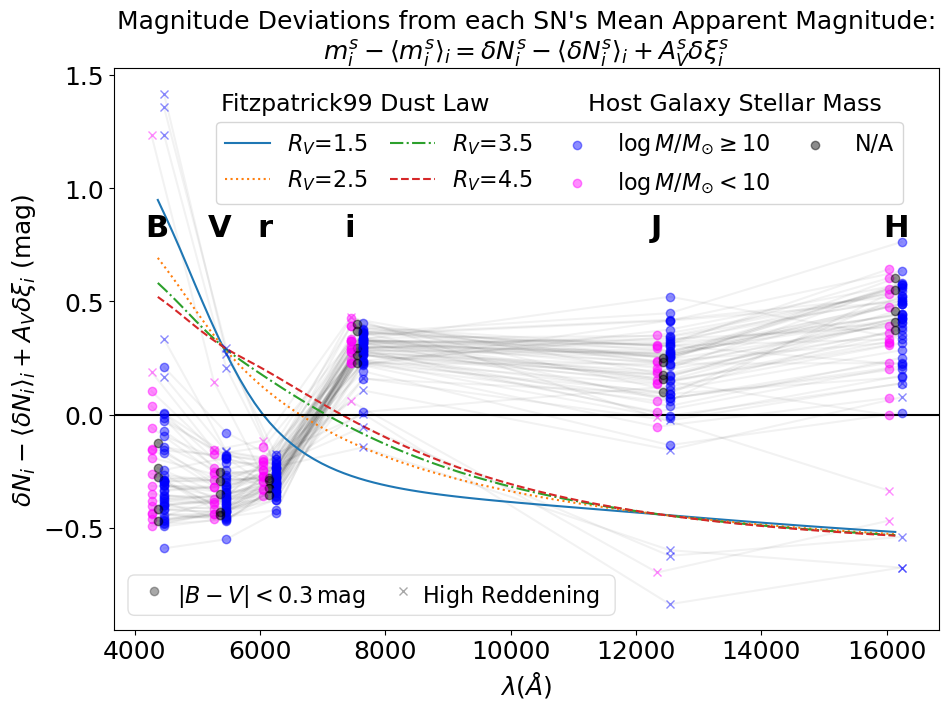

Using effective wavelengths (effective_thetaON): [ 4366.51531373  5361.37548768  6149.07756556  7546.4950165
 12438.1668026  16139.07923279]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/n

2 0 high
2 0 low


/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/Users/samward/opt/anaconda3/envs/rvgps/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

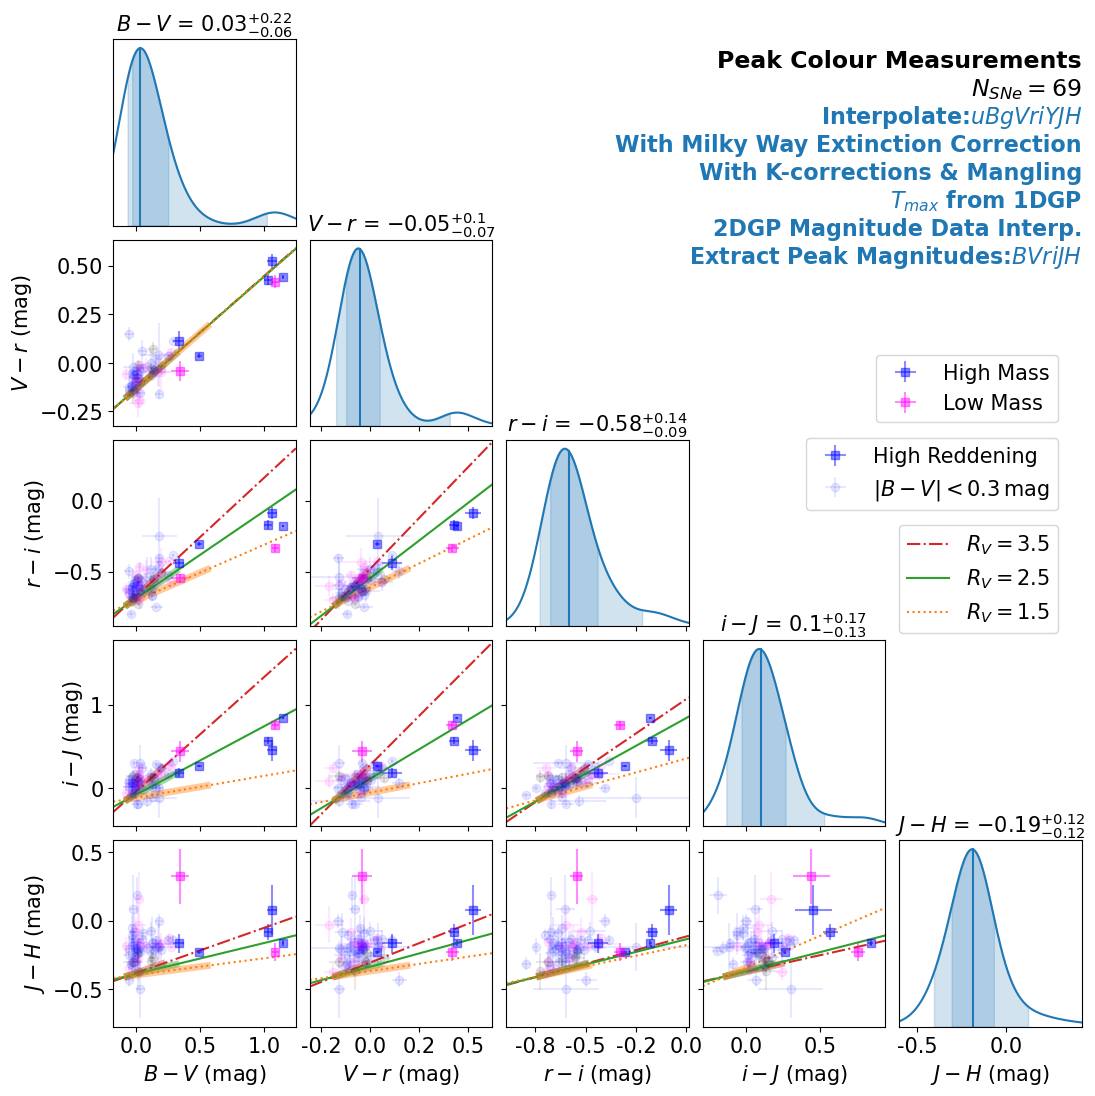

Tmax already estimated
Using Tmax_GP_restframe = 278.76007065436
2004eo: Performing GP Interpolation; flts are:['u', 'B', 'g', 'V', 'r', 'i', 'Y', 'J', 'H']


model_files/GP_functions.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_pred      = np.hstack((x_pred for _ in range(len(lambdaC))))


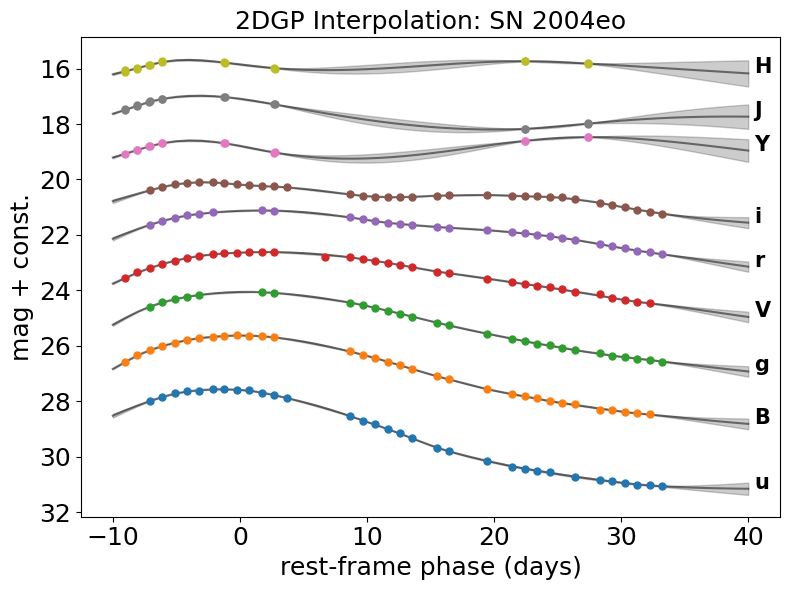

Tmax already estimated
Using Tmax_GP_restframe = 304.32818483752186
2004ey: Performing GP Interpolation; flts are:['u', 'B', 'g', 'V', 'r', 'i', 'Y', 'J', 'H']


model_files/GP_functions.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_pred      = np.hstack((x_pred for _ in range(len(lambdaC))))


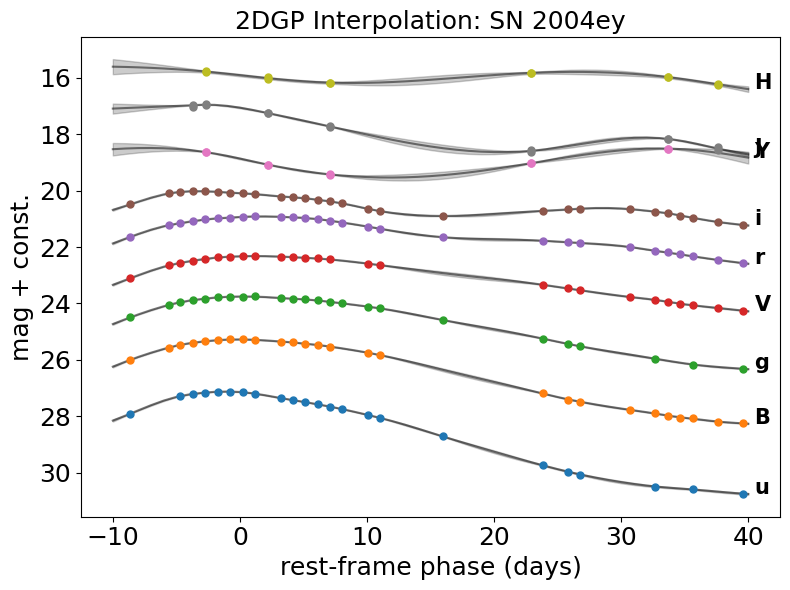

Tmax already estimated
Using Tmax_GP_restframe = 647.3207964774433
2005el: Performing GP Interpolation; flts are:['u', 'B', 'g', 'V', 'r', 'i', 'Y', 'J', 'H']


model_files/GP_functions.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_pred      = np.hstack((x_pred for _ in range(len(lambdaC))))


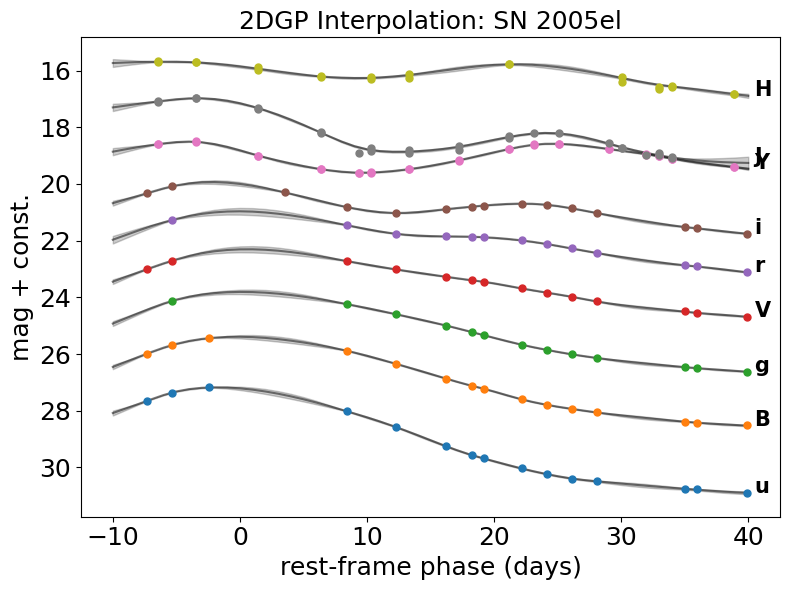

Tmax already estimated
Using Tmax_GP_restframe = 688.1475013042386
2005iq: Performing GP Interpolation; flts are:['u', 'B', 'g', 'V', 'r', 'i', 'Y', 'J', 'H']


model_files/GP_functions.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_pred      = np.hstack((x_pred for _ in range(len(lambdaC))))


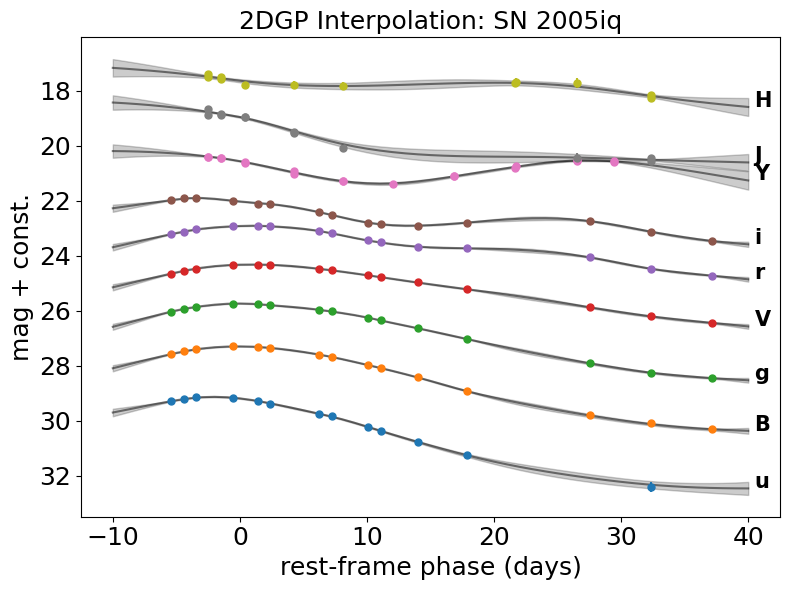

Tmax already estimated
Using Tmax_GP_restframe = 698.0998626866694
2005kc: Performing GP Interpolation; flts are:['u', 'B', 'g', 'V', 'r', 'i', 'Y', 'J', 'H']


model_files/GP_functions.py:269: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x_pred      = np.hstack((x_pred for _ in range(len(lambdaC))))


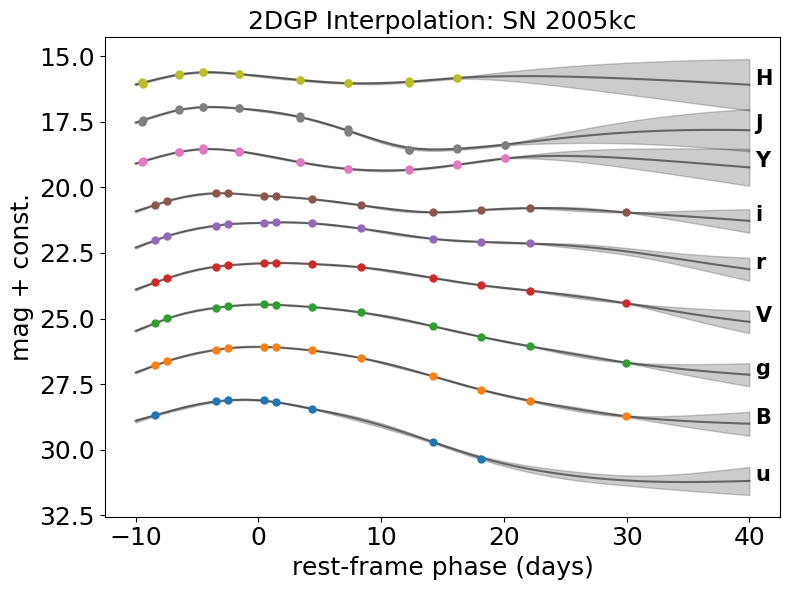

In [6]:
#Show the plots but don't save them
bs.choices['plotting_parameters']['show'] = True
bs.choices['plotting_parameters']['save'] = False

#Plot Mag Deviations
bs.plot_mag_deviations()

#Plot Colours
bs.plot_colour_corner()

#Plot LCs
bs.plot_lcs(sns=bs.sns[:5])

## 7) Perform Hierarchical Bayesian Inference

Run `fit_stan_model` to get the posterior inferences

This command uses the `analysis_parameters` choices in the `.yaml` file.

For example:
* The filename for posterior samples: `HBM_savekey:demo`
* The model for intrinsic chromatic variations: `IntrinsicModel:Deviations`
* The function for the AVs population distribution: `AVprior:Exp`
* Choice to include light curve shape parameters, dm15B: `include_LC_shape:False`
* Choice to include Censored Data (`CensoredData:True`), and the upper bound beyond which SNe are completely excluded from the sample (`CensoredCut:1.0`; corresponding to $B-V=1.0$mag)
* The number of HMC chains, `n_chains:4`, number of posterior samples per chain: `n_sampling:1000`, and warmup per chain `n_warmup:1000`

This example shows how changes can be manually implemented, e.g. here fit the low-reddening sample, include censored SNe, but exclude those with B-V>1.0 mag entirely.


To run this in the jupyter notebook, I have found the following commands are required:

`import nest_asyncio`

`nest_asyncio.apply()`

However, these additional lines are not required when running script locally in python terminal.

In [7]:
#To get model running on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

#Fit Low-Reddening Sample, Censor Objects with 0.3<B-V<1.0 mag, and exclude entirely objects with B-V>1.0 mag
bs.choices['analysis_parameters']['CensoredData'] = True
bs.choices['analysis_parameters']['CensoredCut']  = 1.0

#Fit stan model
bs.fit_stan_model()

## 8) Plot the posterior samples

Rhats: {'tauA': 1.01, 'mu_RV': 1.0, 'sig_RV': 1.0}
###############
tauA: 0.33 +/- 0.06; 16th and 84th intervals: -0.05+0.06
5%, 68%, 95% quantiles: 0.25, 0.36,0.43
###############
mu_RV: 2.57 +/- 0.45; 16th and 84th intervals: -0.38+0.39
5%, 68%, 95% quantiles: 1.72, 2.75,3.23
###############
sig_RV < 0.93 (2.12)
###############
Corner samples/contours plotted successfully


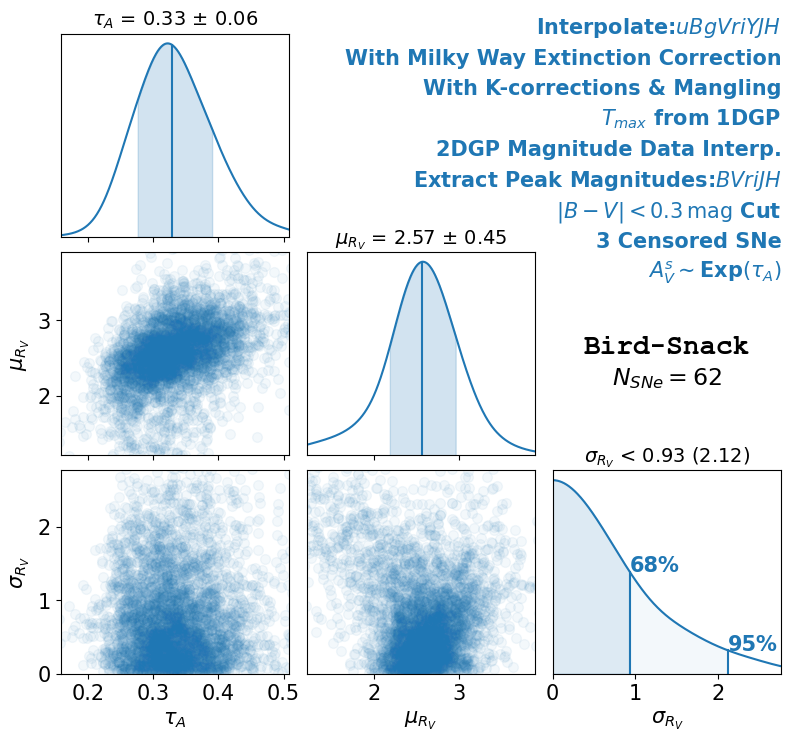

In [8]:
bs.plot_posterior_samples()

## 9) Become a peak Bird-Snack fledgling

Check out further analysis scripts in the `analysis/` directory.

In particular:
* `get_fiducial_sample.py` is used to loop through data from multiple surveys and combine them to create SNSsnpy_combined.pkl, which is then trimmed to create SNSsnpy_fiducial.pkl.
* `analyse_surveys.py` returns statistics on how many SNe were dropped from original sample and why.
* `run_through_analysis_choices.py`. This script facilitates running through many analysis variants in succession, using a set of choices set out in `CYCLE_DICTS.py`.

See also `demo_sbc_ppc.ipynb` for simulating and fitting fake datasets with `BIRDSNACK`.